# Content-Based Movie Recommendation System: Using Sentence-Transformers
* **Content-based recommendation:** Find movies that are similar to those the user has liked in the past.
* Using sentence-transformers to find similar movies. The sentences that are going to be transformed into word vectors are the movie descriptions, which were found in an IMDb dataset: https://www.kaggle.com/stefanoleone992/imdb-extensive-dataset

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Netflix Prize Dataset

In [ ]:
# Netflix Prize dataset ratings file
original_ratings = pd.read_csv('gdrive/My Drive/combined_data_1.txt', header=None, names=['userId', 'rating'], usecols=[0,1])
original_ratings.head()

,userId,rating
0,1:,NaN
1,1488844,3.0
2,822109,5.0
3,885013,4.0
4,30878,4.0


In [ ]:
movie_ids = original_ratings[original_ratings['userId'].str.contains(':')][['userId']]
movie_ids = movie_ids['userId'].str.replace(":", "").astype(int)
movie_ids

0              1
548            2
694            3
2707           4
2850           5
            ... 
24046714    4495
24047329    4496
24056849    4497
24057564    4498
24057834    4499
Name: userId, Length: 4499, dtype: int64

In [ ]:
def to_append(before_index, current_index, movie_id):
    return np.ones(current_index - before_index) * movie_id

# faster with preallocation but simpler approach
start_movie_ids = []
for i in range(1, len(movie_ids)):
    array = to_append(movie_ids.index[i-1], movie_ids.index[i], movie_ids.values[i-1])
    start_movie_ids = np.concatenate((start_movie_ids, array), axis=None)

# adding last movie id
start_movie_ids = np.concatenate((start_movie_ids, np.ones(429) * 4499), axis=None)

In [ ]:
original_ratings['movieId'] = start_movie_ids
original_ratings = original_ratings[['userId', 'movieId', 'rating']]
original_ratings.head()

,userId,movieId,rating
0,1:,1.0,NaN
1,1488844,1.0,3.0
2,822109,1.0,5.0
3,885013,1.0,4.0
4,30878,1.0,4.0


In [ ]:
for col in original_ratings.columns:
    print(col, "NA values:", sum(original_ratings[col].isna()))

userId NA values: 0
movieId NA values: 0
rating NA values: 4499


* There are 4499 movie ids incorrectly within the userId column. Movie ids do not have ratings and so the rating of those rows should be NA. Otherwise, there are no null values. The final dataframe will be completed after dropping where 'rating' is NA, aka the rows where the userId column contains a movieId.

In [ ]:
# Final dataframe
ratings = original_ratings.dropna()
ratings['movieId'] = ratings['movieId'].apply(round) # movieIds showed as floats, rounding for cleanliness
ratings['userId'] = ratings['userId'].astype(int) # Now that the movieIds ("1:") are gone, can make userId nums into ints
ratings.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,userId,movieId,rating
1,1488844,1,3.0
2,822109,1,5.0
3,885013,1,4.0
4,30878,1,4.0
5,823519,1,3.0


In [ ]:
print("Num movies:", len(np.unique(ratings['movieId'])))
print("Num users:", len(np.unique(ratings['userId'])))
print("Num ratings:", ratings.shape[0])

Num movies: 4499
Num users: 470758
Num ratings: 24053764


In [ ]:
# Netfix Prize dataset movies file
movies = pd.read_csv('gdrive/My Drive/movie_titles.csv', encoding='latin1')[['movieId', 'year', 'title']]
movies.head()

,movieId,year,title
0,1,2003.0,Dinosaur Planet
1,2,2004.0,Isle of Man TT 2004 Review
2,3,1997.0,Character
3,4,1994.0,Paula Abdul's Get Up & Dance
4,5,2004.0,The Rise and Fall of ECW


## Dataset Cleaning
* The same cleaning was done in the user-based recommender. Moving that cleaning here.

Unpopular movies will be removed to reduce dimensionality, take up less RAM, and improve computation (since they hold the same weight as popular movies in the matrix).

In [ ]:
# Getting the top 30% most rated movies
movie_size = ratings.groupby('movieId').size()
row_num = len(movie_size) * .70
min_size = movie_size.sort_values()[round(row_num):].values.item(0)
most_rated_movies = movie_size[movie_size > min_size].index

# Removing 70% of the amount of movies, not 70% of ratings (those that were rated the least)
low_rates_removed = ratings.copy()
low_rates_removed = low_rates_removed[low_rates_removed['movieId'].isin(most_rated_movies)]
low_rates_removed.shape

(22626287, 3)

In addition, inactive users will be removed for the same reasons as there are still about 22.6 million rows. Inactive users will be defined by the amount of times they have rated movies.

In [ ]:
# Getting the top 30% most active users
user_size = ratings.groupby('userId').size()
row_num = len(user_size) * .70
min_size = user_size.sort_values()[round(row_num):].values.item(0)
most_active_users = user_size[user_size > min_size].index

# Removing 70% of users due to inactivity
inactive_users_removed = ratings.copy()
inactive_users_removed = inactive_users_removed[inactive_users_removed['userId'].isin(most_active_users)]

# Renaming for clarity
cleaned_ratings = inactive_users_removed.copy()
cleaned_ratings.shape

(18335431, 3)

* When removing the least active 70% of users, 4.3 million ratings have been removed, leaving the dataframe at 18.3 million ratings.

In [ ]:
rates_with_titles = cleaned_ratings.merge(movies, left_on='movieId', right_on='movieId')
rates_with_titles.head()

,userId,movieId,rating,year,title
0,1488844,1,3.0,2003.0,Dinosaur Planet
1,885013,1,4.0,2003.0,Dinosaur Planet
2,30878,1,4.0,2003.0,Dinosaur Planet
3,823519,1,3.0,2003.0,Dinosaur Planet
4,893988,1,3.0,2003.0,Dinosaur Planet


## Incorporating IMDb Movie Descriptions

In [ ]:
imdb = pd.read_csv('gdrive/My Drive/imdb_movies.csv')
imdb = imdb[['title', 'original_title', 'year', 'genre', 'description']]
imdb.head()

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,title,original_title,year,genre,description
0,Miss Jerry,Miss Jerry,1894,Romance,The adventures of a female reporter in the 1890s.
1,The Story of the Kelly Gang,The Story of the Kelly Gang,1906,"Biography, Crime, Drama",True story of notorious Australian outlaw Ned ...
2,Den sorte drøm,Den sorte drøm,1911,Drama,Two men of high rank are both wooing the beaut...
3,Cleopatra,Cleopatra,1912,"Drama, History",The fabled queen of Egypt's affair with Roman ...
4,L'Inferno,L'Inferno,1911,"Adventure, Drama, Fantasy",Loosely adapted from Dante's Divine Comedy and...


In [ ]:
imdb.shape

(85855, 5)

In [ ]:
sum(~(imdb['title'] == imdb['original_title']))

23372

* Use 'title' or 'original_title'? There are 23,372 movies where the title and original title do not match out of 85,855 movies.

In [ ]:
len(movies['title'].values), len(imdb['title'].values)

(17770, 85855)

In [ ]:
len(np.unique(rates_with_titles['title'].values)), len(imdb['title'].values)

(4471, 85855)

* There are 4471 different movies in the cleaned Netflix dataset and 85,855 in the IMDb dataset.

In [ ]:
# Number of overlapping titles between cleaned Netflix and IMDb using column 'title'
count = 0
for movie in np.unique(rates_with_titles['title'].values):
    if movie in imdb['title'].values:
        count += 1
count

906

In [ ]:
# Number of overlapping titles between cleaned Netflix and IMDb using column 'original_title'
count = 0
for movie in np.unique(rates_with_titles['title'].values):
    if movie in imdb['original_title'].values:
        count += 1
count

1943

Since there is a fairly small count of overlapping movies when using the cleaned dataset and because the Surprise library is not being used anymore (no need for more RAM), the original dataset will be used.

In [ ]:
len(movies['title'].values), len(imdb['title'].values)

(17770, 85855)

* There are 17,770 different movies in the cleaned Netflix dataset and 85,855 in the IMDb dataset.

In [ ]:
# Number of overlapping titles between Netflix and IMDb using column 'title'
count = 0
for movie in movies['title'].values:
    if movie in imdb['title'].values:
        count += 1
count

3745

In [ ]:
# Number of overlapping titles between Netflix and IMDb using column 'original_title'
count = 0
for movie in movies['title'].values:
    if movie in imdb['original_title'].values:
        count += 1
count

7787

* It looks like Netflix uses the original titles of movies as there are more overlapping titles with 'original_title'. 'original_title' will be used.

In [ ]:
imdb_subset = imdb[['original_title', 'year', 'genre', 'description']]
imdb_subset.head()

,original_title,year,genre,description
0,Miss Jerry,1894,Romance,The adventures of a female reporter in the 1890s.
1,The Story of the Kelly Gang,1906,"Biography, Crime, Drama",True story of notorious Australian outlaw Ned ...
2,Den sorte drøm,1911,Drama,Two men of high rank are both wooing the beaut...
3,Cleopatra,1912,"Drama, History",The fabled queen of Egypt's affair with Roman ...
4,L'Inferno,1911,"Adventure, Drama, Fantasy",Loosely adapted from Dante's Divine Comedy and...


In [ ]:
movies_descrip = movies.merge(imdb_subset, left_on='title', right_on='original_title')
movies_descrip.head()

,movieId,year_x,title,original_title,year_y,genre,description
0,6,1997.0,Sick,Sick,2012,"Horror, Sci-Fi","Two years into the outbreak, the remaining peo..."
1,10,2001.0,Fighter,Fighter,2007,"Action, Drama",Aicha attends Kung Fu at her high school in Co...
2,10,2001.0,Fighter,Fighter,2019,"Action, Drama, Sport",The story is about a MMA fighter - Tomek Janic...
3,10,2001.0,Fighter,Fighter,2011,Action,Suriya is a college student who lives with his...
4,12,1947.0,My Favorite Brunette,My Favorite Brunette,1947,"Comedy, Crime, Mystery",Shortly before his execution on the death row ...


* There may not truly be 7787 movies in common between the two datasets. This is indicated by the overlapping movie titles that have different publishing years.

In [ ]:
movies_descrip = movies.merge(imdb_subset, left_on=['title', 'year'], right_on=['original_title', 'year']).drop('original_title', axis=1)
movies_descrip.head()

,movieId,year,title,genre,description
0,12,1947,My Favorite Brunette,"Comedy, Crime, Mystery",Shortly before his execution on the death row ...
1,18,1994,Immortal Beloved,"Biography, Drama, Music",The life and death of the legendary Ludwig van...
2,20,1972,Seeta Aur Geeta,"Comedy, Drama, Family",Long-suffering heiress Seeta is treated worse ...
3,22,2000,Chump Change,"Comedy, Romance",Rags to riches to rags comedy loosely based on...
4,24,1981,My Bloody Valentine,"Horror, Mystery, Thriller",A decades-old folk tale surrounding a deranged...


In [ ]:
movies_descrip.shape

(6199, 5)

* When accounting for both the movie title and year, there are only 6199 available descriptions.

In [ ]:
movies.shape

(17770, 3)

* About 11,600 movies were discarded. That is about 65% of the available movies. 65% is less than the amount of movies discarded during the dataset cleaning, which was intentionally 70%. Also, the least popular movies were probably discarded.
* In addition, the purpose of this is notebook is to dabble with word vectorization and content-based recommendation. This count should suffice.

In [ ]:
for col in movies_descrip.columns:
    print(col, sum(movies_descrip[col].isna()))

movieId 0
year 0
title 0
genre 0
description 13


* There are 13 null descriptions. These will be dropped since this content-based analysis is based on the descriptions.

In [ ]:
movies_descrip = movies_descrip.dropna()
movies_descrip.shape

(6186, 5)

In [ ]:
# num movies per year
year_counts = movies_descrip['year'].value_counts().sort_index()
year_counts.head()

1914.0    2
1915.0    1
1919.0    1
1920.0    4
1921.0    3
Name: year, dtype: int64

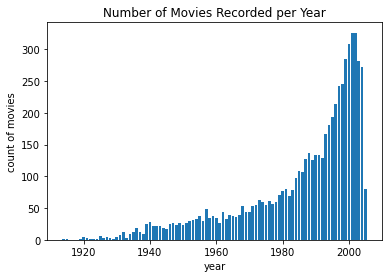

In [ ]:
plt.bar(year_counts.index, year_counts.values)
plt.xlabel('year')
plt.ylabel('count of movies')
plt.title('Number of Movies Recorded per Year');

In [ ]:
print("Mean description length:", round(np.mean(movies_descrip['description'].str.len())))

Mean description length: 146


In [ ]:
# Example of a description
movies_descrip['description'].values.item(0)

'Shortly before his execution on the death row in San Quentin, amateur sleuth and baby photographer Ronnie Jackson, tells reporters how he got there.'

In [ ]:
# A second example of a description
movies_descrip['description'].values.item(1)

'The life and death of the legendary Ludwig van Beethoven. Besides all the work he is known for, the composer once wrote a famous love letter to a nameless beloved, and the movie tries to ...'

* Some descriptions seem to be incomplete.

In [ ]:
# Another example of an incomplete description
movies_descrip[movies_descrip['description'].str.contains("\.\.\.")]['description'].values.item(2)

"Taken from the life story of Leslie Jordan. A Tennessee country boy realizes he's gay and keeps getting in trouble with the local bad boys. He hears Atlanta is the new place to be, tosses ..."

* Although some are incomplete, they are still very informative and will be kept.

## Sentence-Transformers

In [ ]:
!pip install sentence_transformers

     |████████████████████████████████| 71kB 3.5MB/s 
     |████████████████████████████████| 1.3MB 8.3MB/s 
     |████████████████████████████████| 2.9MB 37.3MB/s 
     |████████████████████████████████| 1.1MB 45.9MB/s 
     |████████████████████████████████| 890kB 36.5MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-0.3.9-cp36-none-any.whl size=101036 sha256=6c28b9fb10487f781968b80f4080e56348fc42518fb86865ef92f8788a5f304d
  Stored in directory: /root/.cache/pip/wheels/fc/89/43/f2f5bc00b03ef9724b0f6254a97eaf159a4c4ddc024b33e07a
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=68070f48bed105b2206c25a4c955433ece1d2b8100ec69b48014f535140874e5
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sentence-transformers sacremoses


In [ ]:
# Adding movie titles to the ratings df (originally only had movieIds)
tmp = ratings.merge(movies, left_on='movieId', right_on='movieId')
tmp.head()

,userId,movieId,rating,year,title
0,1488844,1,3.0,2003.0,Dinosaur Planet
1,822109,1,5.0,2003.0,Dinosaur Planet
2,885013,1,4.0,2003.0,Dinosaur Planet
3,30878,1,4.0,2003.0,Dinosaur Planet
4,823519,1,3.0,2003.0,Dinosaur Planet


In [ ]:
# Adding the movie genres and descriptions to the movies and ratings
new_ratings = tmp.merge(imdb, left_on=['title', 'year'], right_on=['original_title', 'year'])
new_ratings = new_ratings[['userId', 'movieId', 'original_title', 'year', 'genre', 'description', 'rating']]
new_ratings = new_ratings.rename(columns={'original_title': 'title'})
new_ratings.head()

,userId,movieId,title,year,genre,description,rating
0,1109700,12,My Favorite Brunette,1947,"Comedy, Crime, Mystery",Shortly before his execution on the death row ...,4.0
1,1056998,12,My Favorite Brunette,1947,"Comedy, Crime, Mystery",Shortly before his execution on the death row ...,5.0
2,903692,12,My Favorite Brunette,1947,"Comedy, Crime, Mystery",Shortly before his execution on the death row ...,3.0
3,2380973,12,My Favorite Brunette,1947,"Comedy, Crime, Mystery",Shortly before his execution on the death row ...,4.0
4,497196,12,My Favorite Brunette,1947,"Comedy, Crime, Mystery",Shortly before his execution on the death row ...,3.0


In [ ]:
new_ratings.shape

(17794962, 7)

* After incorporating the IMDb dataset, there number of ratings became 17.8 million.
* The user-based notebook intentionally reduced the dataset to 18.3 million due to RAM. These are similar numbers.

In [ ]:
# Count of ratings per user
new_ratings.groupby('userId').size().sort_values(ascending=False).head()

userId
305344     1547
387418     1545
2439493    1479
2118461    1451
1664010    1440
dtype: int64

* Among the entries that share a common movie with the imdb description dataset, user 305344 has the most ratings, exactly like the user-based recommender. This user will be used as the first example again.

In [ ]:
user_305344 = new_ratings[new_ratings['userId']==305344]
user_305344.head()

,userId,movieId,title,year,genre,description,rating
344,305344,12,My Favorite Brunette,1947,"Comedy, Crime, Mystery",Shortly before his execution on the death row ...,4.0
7376,305344,18,Immortal Beloved,1994,"Biography, Drama, Music",The life and death of the legendary Ludwig van...,2.0
11345,305344,20,Seeta Aur Geeta,1972,"Comedy, Drama, Family",Long-suffering heiress Seeta is treated worse ...,1.0
11519,305344,22,Chump Change,2000,"Comedy, Romance",Rags to riches to rags comedy loosely based on...,1.0
12467,305344,24,My Bloody Valentine,1981,"Horror, Mystery, Thriller",A decades-old folk tale surrounding a deranged...,1.0


In [ ]:
new_ratings.groupby('movieId').mean()['rating']

movieId
12      3.417582
18      3.784369
20      3.146552
22      2.246305
24      2.993998
          ...   
4487    2.203390
4488    3.554906
4489    3.502849
4492    2.643323
4497    2.715686
Name: rating, Length: 1550, dtype: float64

In [ ]:
# Movies that user 305344 hasn't watched
all_movieIds = np.unique(new_ratings['movieId'])
avail_movies_305344 = [movieId for movieId in all_movieIds if movieId not in user_305344['movieId'].values]
len(avail_movies_305344)

6

* User 305344 has rated 1547 movies out of the 1550 different overlapping movies. There are only 6 movies that the user hasn't watched. The difference in numbers seems to be due to the user re-rating movies. Either way, using this user isn't very telling, so a different, least active user will be observed.

In [ ]:
new_ratings.groupby('userId').size().head()

userId
6     113
7     160
8      19
10     36
25      3
dtype: int64

User 7 will be used (determined only by looking at the head of the df).

In [ ]:
user_7 = new_ratings[new_ratings['userId']==7]
user_7.head()

,userId,movieId,title,year,genre,description,rating
77570,7,30,Something's Gotta Give,2003,"Comedy, Drama, Romance",A swinger on the cusp of being a senior citize...,5.0
180762,7,83,Silkwood,1983,"Biography, Drama, History",A worker at a plutonium processing plant is pu...,5.0
397665,7,175,Reservoir Dogs,1992,"Crime, Drama, Thriller",When a simple jewelry heist goes horribly wron...,5.0
705844,7,257,Charlotte's Web,1973,"Animation, Family, Musical",A gentle and wise grey spider with a flair for...,5.0
763141,7,273,Taxi,2004,"Action, Comedy, Crime",A mouthy and feisty taxicab driver has hot tip...,4.0


In [ ]:
# Movies that user 7 hasn't watched
all_movieIds = np.unique(new_ratings['movieId'])
avail_movies_7 = [movieId for movieId in all_movieIds if movieId not in user_7['movieId'].values]
len(avail_movies_7)

1390

In [ ]:
# The movies User 7 have highly rated (a rating of 4+)
high_rates_7 = user_7[user_7['rating'] >= 4]
high_rates_7.head()

,userId,movieId,title,year,genre,description,rating
77570,7,30,Something's Gotta Give,2003,"Comedy, Drama, Romance",A swinger on the cusp of being a senior citize...,5.0
180762,7,83,Silkwood,1983,"Biography, Drama, History",A worker at a plutonium processing plant is pu...,5.0
397665,7,175,Reservoir Dogs,1992,"Crime, Drama, Thriller",When a simple jewelry heist goes horribly wron...,5.0
705844,7,257,Charlotte's Web,1973,"Animation, Family, Musical",A gentle and wise grey spider with a flair for...,5.0
763141,7,273,Taxi,2004,"Action, Comedy, Crime",A mouthy and feisty taxicab driver has hot tip...,4.0


## Agglomerative Clustering of Transformed Sentences
* Agglomerative clustering will be used to group together descriptions according to proximity in space.
* Agglomerative clustering with sentence-transformers can be found here: https://github.com/UKPLab/sentence-transformers/tree/master/examples/applications/clustering

In [ ]:
from sentence_transformers import SentenceTransformer
from sklearn.cluster import AgglomerativeClustering

embedder = SentenceTransformer('distilroberta-base-paraphrase-v1')

# Corpus with unique movie descriptions
corpus = list(set(new_ratings['description'].dropna()))
corpus_embeddings = embedder.encode(corpus)

# Normalize the embeddings to unit length
corpus_embeddings = corpus_embeddings / np.linalg.norm(corpus_embeddings, axis=1, keepdims=True)

# Perform agglomerative clustering
clustering_model = AgglomerativeClustering(n_clusters=None, distance_threshold=1.5)
clustering_model.fit(corpus_embeddings)
cluster_assignment = clustering_model.labels_

clustered_sentences = {}
for sentence_id, cluster_id in enumerate(cluster_assignment):
    if cluster_id not in clustered_sentences:
        clustered_sentences[cluster_id] = []

    clustered_sentences[cluster_id].append(corpus[sentence_id])

for i, cluster in clustered_sentences.items():
    print("Cluster ", i+1)
    print(cluster)
    print("")

In [ ]:
len(set(new_ratings['description']))

1550

In [ ]:
len(set(cluster_assignment))

212

* The agglomerative clustering algorithm used a count of 212 different clusters.

In [ ]:
# Pairing descriptions with their cluster assignments
descriptions = list(set(new_ratings['description'].dropna()))
clustered = pd.DataFrame({'description': descriptions, 'cluster': cluster_assignment})
clustered.head()

,description,cluster
0,"Spinal Tap, one of England's loudest bands, is...",104
1,A group of inept amateur superheroes must try ...,201
2,"In 1930s New York City, The Shadow (Alec Baldw...",72
3,A housewife who is unhappy with her life befri...,13
4,A handsome Belgian sailor on shore leave in th...,124


* Because a set was used to get unique descriptions for the clustering algorithm, the labels cannot be simply assigned to the original dataframe. Merging needs to be done.

In [ ]:
clusters = clustered.merge(imdb, left_on='description', right_on='description')[['original_title', 'description', 'genre', 'cluster']]
clusters.head()

,original_title,description,genre,cluster
0,This Is Spinal Tap,"Spinal Tap, one of England's loudest bands, is...","Comedy, Music",104
1,Mystery Men,A group of inept amateur superheroes must try ...,"Action, Comedy, Fantasy",201
2,The Shadow,"In 1930s New York City, The Shadow (Alec Baldw...","Action, Adventure, Crime",72
3,Fried Green Tomatoes,A housewife who is unhappy with her life befri...,Drama,13
4,Querelle,A handsome Belgian sailor on shore leave in th...,Drama,124


Now that we have clusters, see which clusters the movies that the user liked are in.

In [ ]:
# Adding cluster labels to User 7's highly rated movies
high_rated_clusters_7 = high_rates_7.merge(clusters, left_on='title', right_on='original_title')[['userId', 'movieId', 'title', 'description_x', 'genre_x', 'rating', 'cluster']]
high_rated_clusters_7 = high_rated_clusters_7.rename(columns={'description_x': 'description', 'genre_x': 'genre'})
high_rated_clusters_7.head()

,userId,movieId,title,description,genre,rating,cluster
0,7,30,Something's Gotta Give,A swinger on the cusp of being a senior citize...,"Comedy, Drama, Romance",5.0,45
1,7,83,Silkwood,A worker at a plutonium processing plant is pu...,"Biography, Drama, History",5.0,194
2,7,175,Reservoir Dogs,When a simple jewelry heist goes horribly wron...,"Crime, Drama, Thriller",5.0,207
3,7,257,Charlotte's Web,A gentle and wise grey spider with a flair for...,"Animation, Family, Musical",5.0,149
4,7,273,Taxi,A mouthy and feisty taxicab driver has hot tip...,"Action, Comedy, Crime",4.0,19


In [ ]:
# Clusters with the most highly rated movies by User 8659
high_rated_clusters_7.groupby('cluster').size().sort_values(ascending=False).head(5)

cluster
53     5
98     4
4      3
147    3
144    2
dtype: int64

In [ ]:
# Looking at the movies within this cluster that the user rated highly
user7_favorite_cluster = high_rated_clusters_7[high_rated_clusters_7['cluster']==53]
user7_favorite_cluster

,userId,movieId,title,description,genre,rating,cluster
6,7,299,Bridget Jones's Diary,Bridget Jones is determined to improve herself...,"Comedy, Drama, Romance",4.0,53
22,7,963,A Streetcar Named Desire,Disturbed Blanche DuBois moves in with her sis...,Drama,5.0,53
31,7,1359,Funny Lady,Story of singer Fanny Brice's stormy relations...,"Biography, Comedy, Drama",5.0,53
58,7,2209,On Golden Pond,Norman is a curmudgeon with an estranged relat...,Drama,5.0,53
105,7,4157,The Prince of Tides,A troubled man talks to his suicidal sister's ...,"Drama, Romance",5.0,53


* There are a lot of movies that the user has rated 5/5 within this cluster, which is a really good sign.

In [ ]:
# All the movies of that cluster
user7_entire_fav_cluster = clusters[clusters['cluster']==53]
user7_entire_fav_cluster

,original_title,description,genre,cluster
130,On Golden Pond,Norman is a curmudgeon with an estranged relat...,Drama,53
264,Danny in the Sky,Danny is a romantic young man looking for love...,Drama,53
278,Marvin's Room,"After 20 years caring for her father, a woman ...",Drama,53
352,A Streetcar Named Desire,Disturbed Blanche DuBois moves in with her sis...,Drama,53
511,Funny Lady,Story of singer Fanny Brice's stormy relations...,"Biography, Comedy, Drama",53
694,Break Up,"Jimmy is married to the abusive Frank, but she...",Thriller,53
754,Playing Mona Lisa,"After being dumped by her boyfriend, a young t...",Comedy,53
773,Simple Men,Bitter about being double-crossed by the women...,"Crime, Drama, Romance",53
863,The Prince of Tides,A troubled man talks to his suicidal sister's ...,"Drama, Romance",53
1125,Bridget Jones's Diary,Bridget Jones is determined to improve herself...,"Comedy, Drama, Romance",53


In [ ]:
# Movies within the cluster that the user has not watched/rated
avail_movies = user7_entire_fav_cluster[~user7_entire_fav_cluster['original_title'].isin(user7_favorite_cluster['title'])]
avail_movies

,original_title,description,genre,cluster
264,Danny in the Sky,Danny is a romantic young man looking for love...,Drama,53
278,Marvin's Room,"After 20 years caring for her father, a woman ...",Drama,53
694,Break Up,"Jimmy is married to the abusive Frank, but she...",Thriller,53
754,Playing Mona Lisa,"After being dumped by her boyfriend, a young t...",Comedy,53
773,Simple Men,Bitter about being double-crossed by the women...,"Crime, Drama, Romance",53
1377,Normal Life,Chris is young idealistic cop who falls in lov...,"Crime, Drama",53


In [ ]:
# Mean ratings of all movies
mean_ratings = new_ratings.groupby('title').mean()['rating']
mean_ratings = mean_ratings.reset_index()
mean_ratings.sort_values('rating', ascending=False)

,title,rating
1371,The Sixth Sense,4.325245
1370,The Silence of the Lambs,4.311687
180,Braveheart,4.294423
123,Batman Begins,4.236699
896,Ray,4.186012
...,...,...
558,Ice from the Sun,1.789474
984,Shanghai Surprise,1.762584
649,Leonard Part 6,1.741697
285,Dark Heaven,1.727723


In [ ]:
# Selecting the movie with the highest mean rating among the unrated movies within that cluster
suggested_movie = avail_movies.merge(mean_ratings, left_on='original_title', right_on='title').sort_values('rating')['original_title'].values.item(0)
suggested_movie

'Danny in the Sky'

In [ ]:
avail_movies.merge(mean_ratings, left_on='original_title', right_on='title').sort_values('rating', ascending=False)

,original_title,description,genre,cluster,title,rating
4,Simple Men,Bitter about being double-crossed by the women...,"Crime, Drama, Romance",53,Simple Men,3.549296
1,Marvin's Room,"After 20 years caring for her father, a woman ...",Drama,53,Marvin's Room,3.320140
5,Normal Life,Chris is young idealistic cop who falls in lov...,"Crime, Drama",53,Normal Life,2.887789
3,Playing Mona Lisa,"After being dumped by her boyfriend, a young t...",Comedy,53,Playing Mona Lisa,2.860707
2,Break Up,"Jimmy is married to the abusive Frank, but she...",Thriller,53,Break Up,2.829132
0,Danny in the Sky,Danny is a romantic young man looking for love...,Drama,53,Danny in the Sky,2.575087


When narrowing it down to a single cluster that contains the most movies the user highly rated, the final output is determined by the average ratings of the movies within the cluster. The movie with the highest average rating will be suggested due to other users liking it the most.

In [ ]:
new_ratings[new_ratings['title']=='Simple Men'].groupby('rating').size()

rating
1.0     32
2.0     46
3.0    112
4.0    128
5.0    108
dtype: int64

* Note that the highest average rating is 4.3 out of 5. The highest rating among the 6 unwatched movies left within User 7's favorite cluster is about 3.6 out of 5. Considering that the highest rated movie is out of 4.3, 3.6 is not low. Looking at the rating distribution above, about 80% of ratings for this move were 3-5 stars, making this is a reasonable average rating and pick.

### Movie Recommender

In [ ]:
def suggested_movies(userId, num_movies=1):
  """Returns the recommended movie(s) and year(s) found by looking at the user's most favored cluster of movies."""
  # Adding cluster labels to userId's highly rated movies
  user = new_ratings[new_ratings['userId']==userId]
  high_rates = user[user['rating'] >= 4]
  high_rated_clusters = high_rates.merge(clusters, left_on='title', right_on='original_title')
  high_rated_clusters = high_rated_clusters[['userId', 'movieId', 'title', 'description_x', 'genre_x', 'rating', 'cluster']]
  high_rated_clusters = high_rated_clusters.rename(columns={'description_x': 'description', 'genre_x': 'genre'})

  # Getting the best cluster (the one that contains most of userId's highly rated movies)
  fave_cluster_num = high_rated_clusters.groupby('cluster').size().sort_values(ascending=False).index[0]

  # Movies within that cluster the user has watched
  user_watched_in_cluster = high_rated_clusters[high_rated_clusters['cluster']==fave_cluster_num]

  # Movies within that cluster the user hasn't watched yet (to use for recommendations)
  user_entire_fave_cluster = clusters[clusters['cluster']==fave_cluster_num]
  avail_movies = user_entire_fave_cluster[~user_entire_fave_cluster['original_title'].isin(user_watched_in_cluster['title'])]
  avail_movie_means = avail_movies.merge(mean_ratings, left_on='original_title', right_on='title').sort_values('rating', ascending=False)

  # The movies the user hasn't watched ordered by average rating (highest to lowest)
  top_movies = avail_movie_means.merge(imdb, left_on=['original_title', 'description'], right_on=['original_title', 'description'])
  top_movies = top_movies[['original_title', 'year', 'rating']]

  if len(top_movies) < num_movies:
    num_movies = len(top_movies)
  
  movie_titles = top_movies['original_title'][:num_movies].values
  years = top_movies['year'][:num_movies].values

  result = []
  for i in range(len(years)):
    result.append([movie_titles[i], int(years[i])])

  return result

In [ ]:
# Top recommended movie for User 10
suggested_movies(10, num_movies=1)

[['Dark Victory', 1939]]

In [ ]:
# Top 2 recommended movies for User 6
suggested_movies(6, num_movies=2)

[['Geronimo: An American Legend', 1993], ['Duel at Diablo', 1966]]

In [ ]:
new_ratings.groupby('userId').size().sort_values(ascending=False).head(15)

userId
305344     1547
387418     1545
2439493    1479
2118461    1451
1664010    1440
1639792    1028
1314869    1016
2143500    1010
752642     1009
1461435     956
716173      951
1114324     949
2056022     939
2606799     925
57633       911
dtype: int64

Let's double check the function's results with User 57633.

In [ ]:
suggested_movies(57633, num_movies=5)

[['Let It Ride', 1989],
 ['The Lemon Drop Kid', 1951],
 ['Go West', 1925],
 ['Rat Race', 2001],
 ['Saint Jack', 1979]]

In [ ]:
# Adding cluster labels to userId's highly rated movies
user = new_ratings[new_ratings['userId']==57633]
high_rates = user[user['rating'] >= 4]
high_rated_clusters = high_rates.merge(clusters, left_on='title', right_on='original_title')
high_rated_clusters = high_rated_clusters[['userId', 'movieId', 'title', 'description_x', 'genre_x', 'rating', 'cluster']]
high_rated_clusters = high_rated_clusters.rename(columns={'description_x': 'description', 'genre_x': 'genre'})

# Getting the best cluster (the one that contains most of userId's highly rated movies)
fave_cluster_num = high_rated_clusters.groupby('cluster').size().sort_values(ascending=False).index[0]

# Movies within that cluster the user has watched
user_watched_in_cluster = high_rated_clusters[high_rated_clusters['cluster']==fave_cluster_num]

# Movies within that cluster the user hasn't watched yet (to use for recommendations)
user_entire_fave_cluster = clusters[clusters['cluster']==fave_cluster_num]
avail_movies = user_entire_fave_cluster[~user_entire_fave_cluster['original_title'].isin(user_watched_in_cluster['title'])]
avail_movie_means = avail_movies.merge(mean_ratings, left_on='original_title', right_on='title').sort_values('rating', ascending=False)

# The movies the user hasn't watched ordered by average rating (highest to lowest)
top_movies = avail_movie_means.merge(imdb, left_on=['original_title', 'description'], right_on=['original_title', 'description'])
top_movies = top_movies[['original_title', 'year', 'rating']]
top_movies.head()

,original_title,year,rating
0,Let It Ride,1989,3.496454
1,The Lemon Drop Kid,1951,3.496000
2,Go West,1925,3.374674
3,Rat Race,2001,3.305349
4,Saint Jack,1979,2.989691


In [ ]:
high_rated_clusters.groupby('cluster').size().sort_values(ascending=False).head()

cluster
118    4
7      4
92     4
13     4
29     3
dtype: int64

In [ ]:
high_rated_clusters[high_rated_clusters['cluster']==118]

,userId,movieId,title,description,genre,rating,cluster
11,57633,241,North by Northwest,A New York City advertising executive goes on ...,"Adventure, Mystery, Thriller",5.0,118
63,57633,1466,Midnight Cowboy,A naive hustler travels from Texas to New York...,Drama,4.0,118
124,57633,2905,Croupier,An aspiring writer is hired as a croupier at a...,"Crime, Drama",4.0,118
175,57633,4109,American Psycho,A wealthy New York City investment banking exe...,"Comedy, Crime, Drama",4.0,118


In [ ]:
avail_movies

,original_title,description,genre,cluster
321,Let It Ride,A nosy cab driver gets a hot tip on a race hor...,"Comedy, Action",118
325,Go West,With little luck at keeping a job in the city ...,"Comedy, Western",118
481,Empire of the Ants,Con artist Marilyn Fryser tries to sell bogus ...,"Adventure, Horror, Sci-Fi",118
641,Rat Race,"A Las Vegas casino magnate, determined to find...","Action, Adventure, Comedy",118
762,Saint Jack,"Jack Flowers, an American hustler in early 197...",Drama,118
1521,The Lemon Drop Kid,A New York City swindler has until Christmas t...,"Comedy, Crime, Music",118


In [ ]:
user_watched_in_cluster

,userId,movieId,title,description,genre,rating,cluster
11,57633,241,North by Northwest,A New York City advertising executive goes on ...,"Adventure, Mystery, Thriller",5.0,118
63,57633,1466,Midnight Cowboy,A naive hustler travels from Texas to New York...,Drama,4.0,118
124,57633,2905,Croupier,An aspiring writer is hired as a croupier at a...,"Crime, Drama",4.0,118
175,57633,4109,American Psycho,A wealthy New York City investment banking exe...,"Comedy, Crime, Drama",4.0,118


The variables return what are expected. Also, the cluster that User 57633 favored the most contains movies with common genres, which are drama, crime, and adventure. The cluster that User 7 favored the most also shared common genres. This shows that the clustering technique with sentence-transformers applied to movie descriptions is working well.

### Lastly, I will make an additional function where you can enter titles and years of movies you **liked** (rating 3+) and your ratings for them to receive recommended movies in return.
* This will be done by getting the pre-assigned cluster numbers of the entered movies, finding all of the movies within those clusters, removing the entered movies from this list of movies, then finding the movies that are most similar to the entered movies via sentence-transformers and cosine similarity.

In [ ]:
# organizing a user's entries
df = pd.DataFrame()
movies = ["Something's Gotta Give", "The Love Letter", "Wonder Boys"]
years = [2003, 1999, 2000]
ratings = [4,3,5]
df['title'] = movies
df['year'] = years
df['rating'] = ratings
df

,title,year,rating
0,Something's Gotta Give,2003,4
1,The Love Letter,1999,3
2,Wonder Boys,2000,5


In [ ]:
# adding genres and descriptions
reports = df.merge(imdb, left_on='title', right_on='original_title')[['original_title', 'year_x', 'genre', 'description', 'rating']].rename(columns={'year_x': 'year'})
reports

,original_title,year,genre,description,rating
0,Something's Gotta Give,2003,"Comedy, Drama, Romance",A swinger on the cusp of being a senior citize...,4
1,The Love Letter,1999,"Comedy, Drama, Romance",The life of a provincial town becomes stormy a...,3
2,Wonder Boys,2000,"Comedy, Drama",An English Professor tries to deal with his wi...,5


In [ ]:
# adding cluster labels
reports = clusters[clusters['original_title'].isin(reports['original_title'])]
reports

,original_title,description,genre,cluster
38,Something's Gotta Give,A swinger on the cusp of being a senior citize...,"Comedy, Drama, Romance",45
634,Wonder Boys,An English Professor tries to deal with his wi...,"Comedy, Drama",34
1463,The Love Letter,The life of a provincial town becomes stormy a...,"Comedy, Drama, Romance",46


In [ ]:
# getting movies within all of the relevant clusters
cluster_movies = clusters[clusters['cluster'].isin(reports['cluster'])]
avail_movies = cluster_movies[~cluster_movies['original_title'].isin(reports['original_title'])]
avail_movies.head()

,original_title,description,genre,cluster
175,The Best Little Whorehouse in Texas,A town's Sheriff and regular patron of a histo...,"Comedy, Musical",46
202,At the Earth's Core,A Victorian era scientist and his assistant ta...,"Adventure, Fantasy, Sci-Fi",34
334,Mann,A young woman falls in love with a handsome pl...,"Drama, Romance",45
344,Journey to the Center of the Earth,An Edinburgh professor and assorted colleagues...,"Adventure, Family, Fantasy",34
471,Refugee,A young man who smuggles illegal weapons and p...,"Drama, Musical, Romance",45


In [ ]:
# SIMILARITY
sbert_model = SentenceTransformer('bert-base-nli-mean-tokens')

sentences = avail_movies['description'].values
sentence_embeddings = sbert_model.encode(sentences)

100%|██████████| 405M/405M [00:19<00:00, 21.3MB/s]


In [ ]:
def cosine(u, v):
    """Returns the cosine similarity between descriptions."""
    return np.dot(u, v) / (np.linalg.norm(u) * np.linalg.norm(v))

# get most similar descriptions
top_similarity = {}
for query in reports['description'].values:
  query_vec = sbert_model.encode([query])[0]
  max_sim = 0
  max_sent = ""
  for sent in sentences:
    sim = cosine(query_vec, sbert_model.encode([sent])[0])
    if sim > max_sim:
      max_sim = sim
      max_sent = sent
  top_similarity[max_sent] = max_sim
  print(max_sent, "|", max_sim)

A young woman falls in love with a handsome playboy, while aboard a Singapore to India cruise. They make plans to meet again, but fate may have other plans... | 0.76895124
A college professor wakes up to find his wife has not returned home, then struggles to understand her disappearance. | 0.7430485
An English professor finds his life crumbling around him. | 0.63351405


In [ ]:
def enter_for_recommendation(movies, years, ratings, num_movies=1):
  """Returns the recommended movie(s), year(s), and genre(s) according 
     to similarity between the movies entered and those not watched."""
  df = pd.DataFrame()
  df['title'] = movies
  df['year'] = years
  df['rating'] = ratings

  # adding genre and descriptions
  reports = df.merge(imdb, left_on='title', right_on='original_title')
  reports = reports[['original_title', 'year_x', 'genre', 'description', 'rating']].rename(columns={'year_x': 'year'})

  # adding cluster labels to entered movies
  reports = clusters[clusters['original_title'].isin(reports['original_title'])]

  # getting movies within all of the relevant clusters
  cluster_movies = clusters[clusters['cluster'].isin(reports['cluster'])]
  avail_movies = cluster_movies[~cluster_movies['original_title'].isin(reports['original_title'])]
  
  # getting most similar descriptions
  top_similarity = {}
  for query in reports['description'].values:
    query_vec = sbert_model.encode([query])[0]
    max_sim = 0
    max_sent = ""
    for sent in sentences:
      sim = cosine(query_vec, sbert_model.encode([sent])[0])
      if sim > max_sim:
        max_sim = sim
        max_sent = sent
    top_similarity[max_sent] = max_sim

  if len(top_similarity) < num_movies:
    num_movies = len(top_similarity)

  final_df = pd.DataFrame(top_similarity.items())
  final_df = final_df.rename(columns={0:'description', 1:'similarity'}).sort_values('similarity', ascending=False)
  result = final_df.merge(imdb, left_on='description', right_on='description')
  resulting_movies = result['original_title'][:num_movies].values
  resulting_years = result['year'][:num_movies].values
  resulting_genres = result['genre'][:num_movies].values

  output = []
  for i in range(len(resulting_movies)):
    output.append([resulting_movies[i], int(resulting_years[i]), resulting_genres[i]])
  return output # movie, year, genre

* Genres are returned this time because someone can enter a group of movies that all have very different genres. Now a user can pick according to the genre they currently want to watch.

In [ ]:
movies = ["Something's Gotta Give", "The Love Letter", "Wonder Boys"]
years = [2003, 1999, 2000]
ratings = [4,3,5]
enter_for_recommendation(movies, years, ratings, num_movies=2)

[['Mann', 1999, 'Drama, Romance'],
 ['Chasing Sleep', 2000, 'Drama, Horror, Mystery']]